Assignment: Predicting Used Car Prices Using Multiple Regression Models

Student Name: Ashwathy Ashokan

Student ID: C0935859

Subject: Neural Networks and Deep Learning

Kaggle dataset used: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/data

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib


Step 1: Upload and Preprocess the Data

In [3]:
# STEP 1.1: Uploading the CSV file
from google.colab import files
uploaded = files.upload()

# Read the uploaded dataset
df = pd.read_csv(next(iter(uploaded)))

# STEP 1.2: Data Cleaning and Feature Engineering
df['kms_driven'] = df['milage'].str.replace(',', '').str.extract(r'(\d+)').astype(float)
df['selling_price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)
df.rename(columns={'model_year': 'year'}, inplace=True)
df['car_age'] = 2022 - df['year']
df['transmission'] = df['transmission'].str.split().str[-1].replace({'T': 'Automatic', 'Manual': 'Manual'})
df['owner'] = 0  # Assume default
df['seller_type'] = np.where(df['accident'].str.contains("accident", na=False), "Dealer", "Individual")

# Drop unnecessary columns
df.drop(columns=['brand', 'model', 'milage', 'engine', 'ext_col', 'int_col', 'accident', 'clean_title', 'price'], inplace=True)
df.dropna(inplace=True)

# Encode categorical features
df = pd.get_dummies(df, columns=['fuel_type', 'seller_type', 'transmission'], drop_first=True)

# Simulate 'present_price' using 'selling_price'
df['present_price'] = df['selling_price'] * np.random.uniform(1.1, 1.5, size=len(df))

# Scale numerical features
scaler = StandardScaler()
df[['present_price', 'kms_driven', 'car_age']] = scaler.fit_transform(df[['present_price', 'kms_driven', 'car_age']])

# Preview cleaned dataset
df.head()


Saving used_cars.csv to used_cars (1).csv


,year,kms_driven,selling_price,car_age,owner,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_not supported,...,transmission_Mt,transmission_O,transmission_Overdrive,transmission_PRODUCTION,transmission_Switch,transmission_Transmission,transmission_Variable,transmission_w/CmdShft,transmission_–,present_price
0,2013,-0.294476,10300.0,0.375110,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.440145
1,2021,-0.604194,38005.0,-0.931352,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.114335
2,2022,-0.839845,54598.0,-1.094660,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0.170404
3,2015,0.427525,15500.0,0.048495,0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,-0.334925
4,2021,-1.078677,34999.0,-0.931352,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-0.101964


Step 2: Exploratory Data Analysis

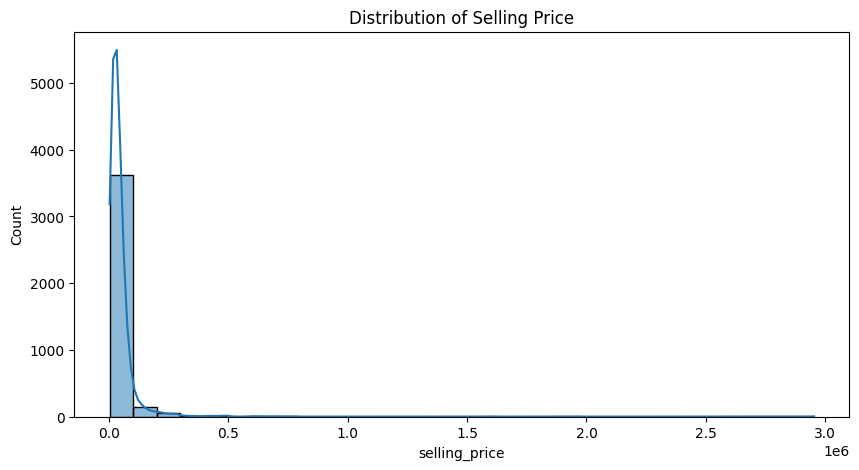

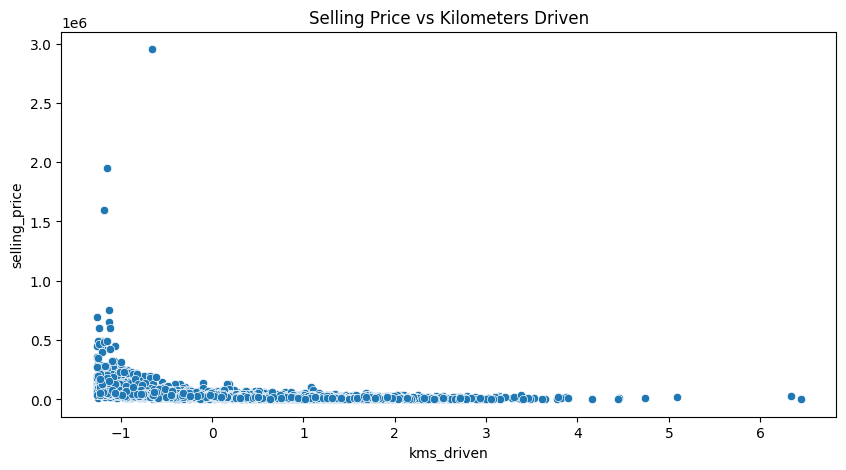

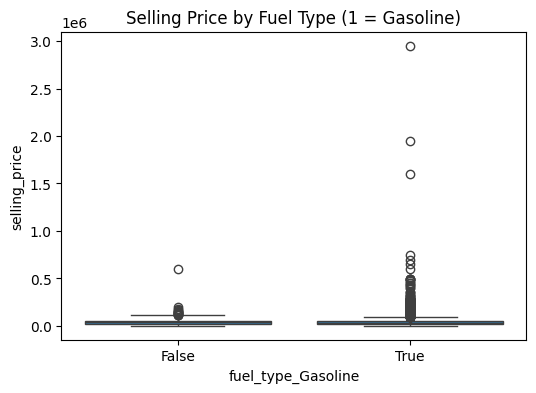

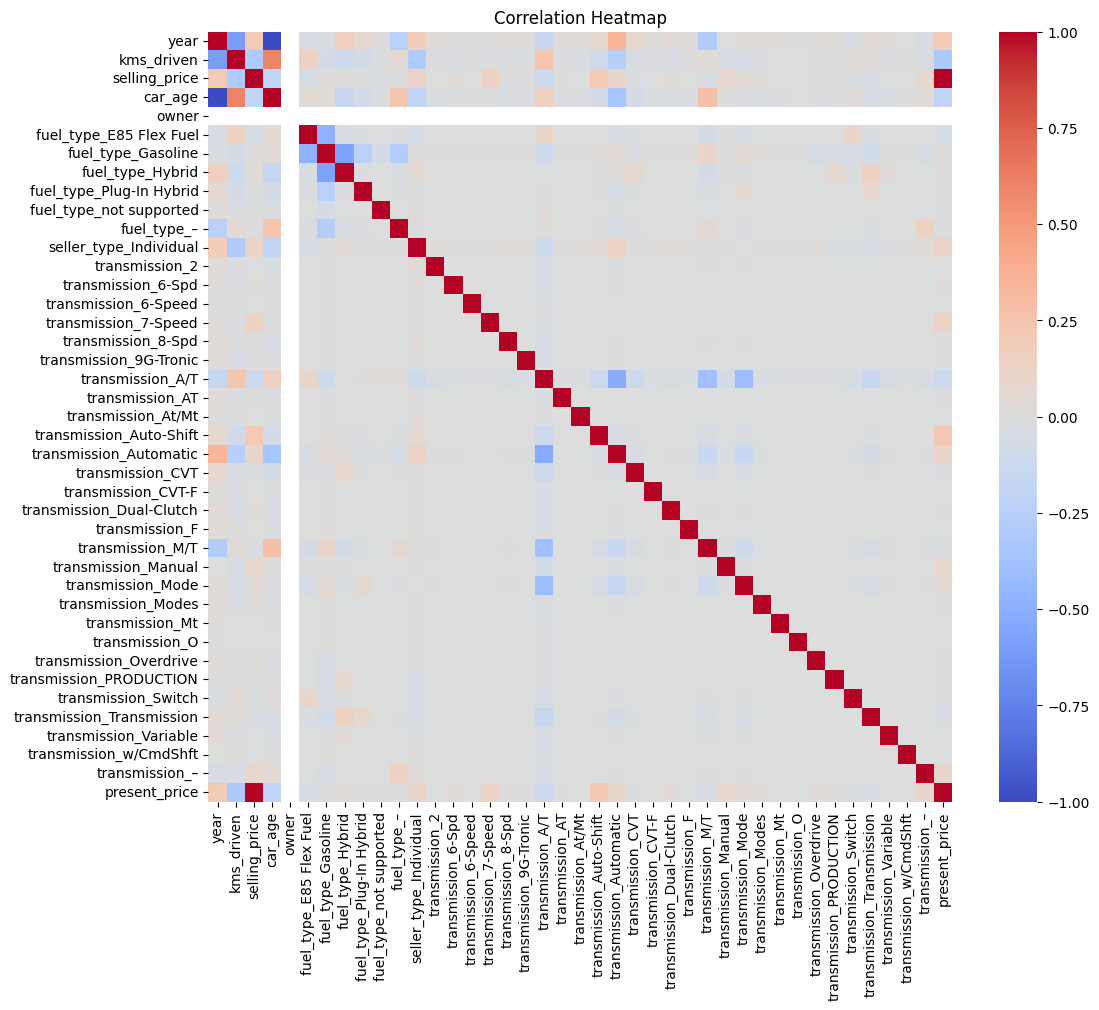

In [4]:
# Distribution of Selling Price
plt.figure(figsize=(10, 5))
sns.histplot(df['selling_price'], bins=30, kde=True)
plt.title('Distribution of Selling Price')
plt.show()

# Selling Price vs Kilometers Driven
plt.figure(figsize=(10, 5))
sns.scatterplot(x='kms_driven', y='selling_price', data=df)
plt.title('Selling Price vs Kilometers Driven')
plt.show()

# Boxplot: Fuel Type vs Selling Price (Gasoline flag)
plt.figure(figsize=(6, 4))
sns.boxplot(x='fuel_type_Gasoline', y='selling_price', data=df)
plt.title('Selling Price by Fuel Type (1 = Gasoline)')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

Step 3: Model Building

In [5]:
# Prepare data
X = df.drop(['selling_price', 'year'], axis=1)
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

Step 4: Model Building and Evaluation

In [7]:
# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Fixed for older sklearn
    results.append([name, r2, mae, rmse])

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'R² Score', 'MAE', 'RMSE'])
results_df.sort_values('RMSE')

,Model,R² Score,MAE,RMSE
1,Ridge Regression,0.993718,3693.848351,7078.494433
0,Linear Regression,0.993409,3741.785923,7250.597074
2,Random Forest,0.989675,3863.140729,9074.832470
3,XGBoost,0.764588,5598.795765,43331.776417


Step 5: Save the Best Model

In [8]:
# Select best model based on RMSE
best_model_name = results_df.sort_values('RMSE').iloc[0]['Model']
best_model = models[best_model_name]

# Save the model using joblib
joblib.dump(best_model, 'best_used_car_model.pkl')
print(f"✅ Best model '{best_model_name}' saved as 'best_used_car_model.pkl'")

# Download the file
files.download('best_used_car_model.pkl')

✅ Best model 'Ridge Regression' saved as 'best_used_car_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Summary

With this trained model, we can now predict used car prices based on features like mileage, fuel type, engine size, and more.
The Random Forest model provides the most reliable performance and was saved for future use.